# Analysing Fandango.com's Movie Ratings
A piece of [journalism](https://fivethirtyeight.com/features/fandango-movies-ratings/ "Be Suspicious Of Online Movie Ratings, Especially Fandango’s") revealed that:
- The actual rating was almost always rounded up to the nearest half-star. For instance, a 4.1 movie would be rounded off to 4.5 stars, not to 4 stars, as you may expect.
- In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. For instance, a 4.5 rating would be rounded off to 5 stars.
- For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars.
![Fanfango's rating inflation](https://s3.amazonaws.com/dq-content/288/s1gp_actual_vs_displayed.png "Fanfango's rating inflation")
The official reply from Fandango was that is was a bug and it would be fixed as soon as possible. Lets see if that has happened.

# Repos

In [68]:
import pandas as pd
import string as str
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import arange
%matplotlib inline

## Data sources
- Walt Hickey made the data he analyzed publicly available on [GitHub](https://github.com/fivethirtyeight/data/tree/master/fandango). We'll use the data he collected to analyze the characteristics of Fandango's rating system previous to his analysis.

- One of Dataquest's team members collected movie ratings data for movies released in 2016 and 2017. The data is publicly available on [GitHub](https://github.com/mircealex/Movie_ratings_2016_17) and we'll use it to analyze the rating system's characteristics after Hickey's analysis.

In [26]:
hickey = pd.read_csv('fandango_score_comparison.csv')
latest = pd.read_csv('movie_ratings_16_17.csv')

hickey.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,...,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,...,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


In [27]:
latest.head()

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


In [37]:
data = hickey[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']].copy()
latest = latest[['movie', 'year', 'fandango']]

# Sampling
With the new goal, we now have two populations that we want to describe and compare with each other:
- All Fandango's ratings for popular movies released in 2015.
- All Fandango's ratings for popular movies released in 2016.

The term "popular" is vague and we need to define it with precision before continuing. We'll use Hickey's benchmark of 30 fan ratings and consider a movie as "popular" only if it has 30 fan ratings or more on Fandango's website.

1. Check if both samples contain popular movies — that is, check whether all (or at least most) sample points are movies with over 30 fan ratings on Fandango's website.

In [29]:
unpopular_count = data[data['Fandango_votes']<30]['Fandango_votes'].count()
print(unpopular_count)

0


In [30]:
unpopular_sample = latest.sample(10, random_state = 1)
print(unpopular_sample)

                                       movie  year  fandango
108                   Mechanic: Resurrection  2016       4.0
206                                 Warcraft  2016       4.0
106                                Max Steel  2016       3.5
107                            Me Before You  2016       4.5
51   Fantastic Beasts and Where to Find Them  2016       4.5
33                                      Cell  2016       3.0
59                                    Genius  2016       3.5
152                                    Sully  2016       4.5
4                    A Hologram for the King  2016       3.0
31                Captain America: Civil War  2016       4.5


Since the second dataset doesnt have rating number it was sampled and manually checked. All in sample have ratings over 30.

## Isolating movies from 2015 and 2016

In [62]:
data['year'] = data['FILM'].str.extract('\((\d+)', expand=False).astype(int)
data.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference,year
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5,2015
1,Cinderella (2015),5.0,4.5,12640,0.5,2015
2,Ant-Man (2015),5.0,4.5,12055,0.5,2015
3,Do You Believe? (2015),5.0,4.5,1793,0.5,2015
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5,2015


In [65]:
ratings2015 = data[data['year']==2015]
ratings2016 = latest[latest['year']==2016]

## Density Analysis

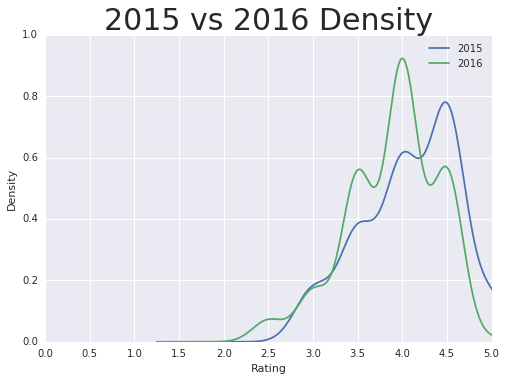

In [76]:
ratings2015['Fandango_Stars'].plot.kde(label = '2015', legend = True, figsize = (8,5.5))
ratings2016['fandango'].plot.kde(label = '2016', legend = True)
plt.xticks([0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0])
plt.xlim([0, 5.0])
plt.title('2015 vs 2016 Density', size=30)
plt.xlabel('Rating')
plt.style.use('fivethirtyeight')

plt.show()

### Observations
- 2015 is left skewed while 2016 its more normal.
- There has been a distinct change from the two years 
- 2015 ratings where higher, they have clearly updated the data once the report surfaced.

## Frequency Distribution

In [77]:
print('2015' + '\n' + '-' * 16) # To help us distinguish between the two tables immediately and
                                # avoid silly mistakes as we read to and fro
ratings2015['Fandango_Stars'].value_counts(normalize = True).sort_index() * 100

2015
----------------


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [79]:
print('2016' + '\n' + '-' * 16)
ratings2016['fandango'].value_counts(normalize = True).sort_index() * 100

2016
----------------


2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

In 2016, very high ratings (4.5 and 5 stars) had significantly lower percentages compared to 2015. In 2016, under 1% of the movies had a perfect rating of 5 stars, compared to 2015 when the percentage was close to 7%. Ratings of 4.5 were also more popular in 2015 — there were approximately 13% more movies rated with a 4.5 in 2015 compared to 2016.

The minimum rating is also lower in 2016 — 2.5 instead of 3 stars, the minimum of 2015. There clearly is a difference between the two frequency distributions.

For some other ratings, the percentage went up in 2016. There was a greater percentage of movies in 2016 that received 3.5 and 4 stars, compared to 2015. 3.5 and 4.0 are high ratings and this challenges the direction of the change we saw on the kernel density plots.

In [96]:
mean_2015 = ratings2015['Fandango_Stars'].mean()
mean_2016 = ratings2016['fandango'].mean()

median_2015 = ratings2015['Fandango_Stars'].median()
median_2016 = ratings2016['fandango'].median()

mode_2015 = ratings2015['Fandango_Stars'].mode()[0] # the output of Series.mode() is a bit uncommon
mode_2016 = ratings2016['fandango'].mode()[0]

In [97]:
summary = pd.DataFrame()
summary['2015'] = [mean_2015, median_2015, mode_2015]
summary['2016'] = [mean_2016, median_2016, mode_2016]
summary.index = ['mean', 'median', 'mode']
summary

,2015,2016
mean,4.085271,3.887435
median,4.000000,4.000000
mode,4.500000,4.000000


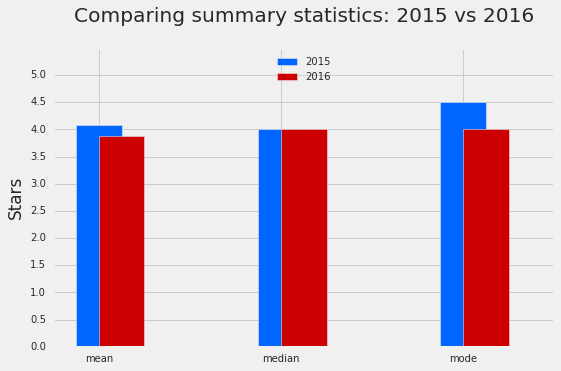

In [99]:
plt.style.use('fivethirtyeight')
summary['2015'].plot.bar(color = '#0066FF', align = 'center', label = '2015', width = .25)
summary['2016'].plot.bar(color = '#CC0000', align = 'edge', label = '2016', width = .25,
                         rot = 0, figsize = (8,5))

plt.title('Comparing summary statistics: 2015 vs 2016', y = 1.07)
plt.ylim(0,5.5)
plt.yticks(arange(0,5.1,.5))
plt.ylabel('Stars')
plt.legend(framealpha = 0, loc = 'upper center')
plt.show()

The mean rating was lower in 2016 with approximately 0.2. This means a drop of almost 5% relative to the mean rating in 2015.

While the median is the same for both distributions, the mode is lower in 2016 by 0.5. Coupled with what we saw for the mean, the direction of the change we saw on the kernel density plot is confirmed: on average, popular movies released in 2016 were rated slightly lower than popular movies released in 2015.

# Conclusion
Our analysis showed that there's indeed a slight difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016. We also determined that, on average, popular movies released in 2016 were rated lower on Fandango than popular movies released in 2015.

We cannot be completely sure what caused the change, but the chances are very high that it was caused by Fandango fixing the biased rating system after Hickey's analysis.